In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from skimage import data
from skimage import color
from skimage.util.shape import view_as_windows
from skimage.util import montage as montage2d
from skimage.io import imread
from skimage.transform import resize
from skimage.util import view_as_blocks
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
import seaborn as sns

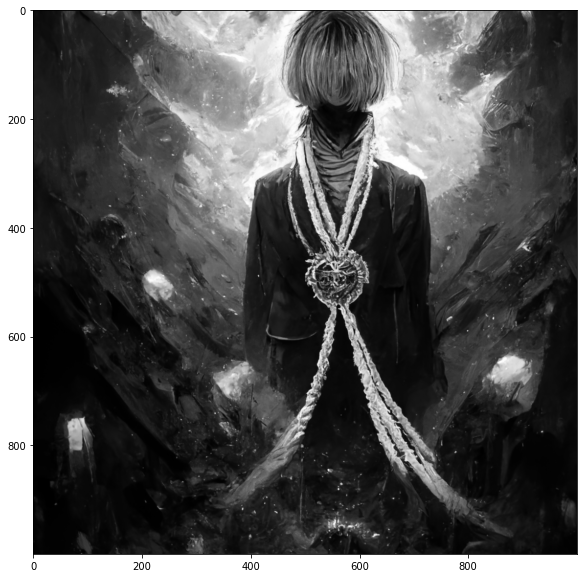

In [ ]:
puzzle = imread("/content/kurc.png",as_gray = True)
puzzle = resize(puzzle,(1000,1000))
puzzle.shape
fig = plt.figure(figsize=(10,10))
plt.imshow(puzzle,cmap = plt.cm.gray)

In [ ]:
puzzle.shape

(1000, 1000)

In [ ]:
puzzle_shape = (200,200)
puzzle_blocks_orig = view_as_blocks(puzzle, block_shape = puzzle_shape)
puzzle_blocks_orig.shape

(5, 5, 200, 200)

In [ ]:
puzzle_blocks = puzzle_blocks_orig
puzzle_blocks = puzzle_blocks.reshape((-1,)+puzzle_shape)
puzzle_blocks.shape

(25, 200, 200)

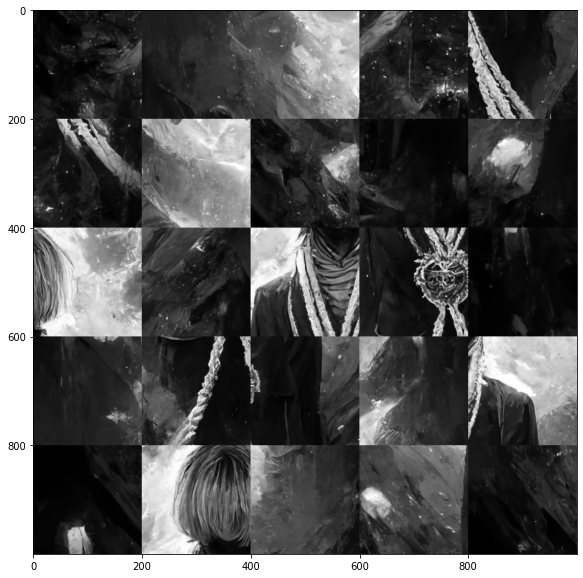

In [ ]:
np.random.shuffle(puzzle_blocks)
puzzle_montage = montage2d(puzzle_blocks)
fig = plt.figure(figsize=(10,10))
plt.imshow(puzzle_montage,cmap = plt.cm.gray)

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
from skimage.util import view_as_blocks
from sklearn.feature_extraction.image import extract_patches_2d

In [ ]:
# A = puzzle_blocks[12]
# B = puzzle_blocks[13]
# A

In [ ]:
# T = A[0,:].reshape(1,-1)
# R = A[:,0:1].reshape(1,-1)
# D = A[199,:].reshape(1,-1)
# L = A[:,199].reshape(1,-1)
# L

In [ ]:
# bw = 1
# orientations = ['bottom','top','left','right']
# top_ = lambda X,bw: X[0:bw,:].reshape(1,-1)
# left_ = lambda X,bw: X[:,0:bw].reshape(1,-1)
# bottom_ = lambda X,bw: X[199,:].reshape(1,-1)
# right_ = lambda X,bw: X[:,199].reshape(1,-1)

bw = 1
orientations = ['bottom','top','left','right']
top_ = lambda X,bw: X[0:bw,:].reshape(1,-1)
right_ = lambda X,bw: X[:,0:bw].reshape(1,-1)
bottom_ = lambda X,bw: X[(-1-bw):-1,:].reshape(1,-1)
left_ = lambda X,bw: X[:,(-1-bw):+-1].reshape(1,-1)


In [ ]:
def edge_distances(A,B):
  bw=1
  d1 = pairwise_distances(top_(A,bw),bottom_(B,bw),metric = "cosine")[0][0]
  d2 = pairwise_distances(bottom_(A,bw),top_(B,bw),metric = "cosine")[0][0]
  d3 = pairwise_distances(right_(A,bw),left_(B,bw),metric = "cosine")[0][0]
  d4 = pairwise_distances(left_(A,bw),right_(B,bw),metric = "cosine")[0][0]
  return [d1,d2,d3,d4]

In [ ]:
# [d1,d2,d3,d4] = edge_distances(A,B)
# ed = [d1,d2,d3,d4]
# mn = np.min(ed)
# agmn = np.argmin(ed)
# agmn

In [ ]:
def piece_dissimilarity(A,B):
  ed = edge_distances(A,B)
  return np.min(ed),np.argmin(ed)

In [ ]:
n = puzzle_blocks.shape[0]
Ke = np.zeros((n,n))
KeO = np.zeros((n,n))
for i in np.arange(n):
  for j in np.arange(n):
    Ke[i,j],KeO[i,j] = piece_dissimilarity(puzzle_blocks[i],puzzle_blocks[j])

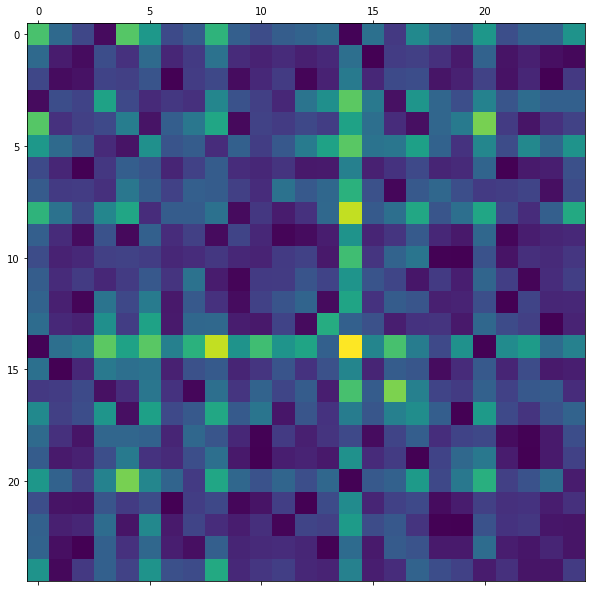

In [ ]:
plt.figure(figsize=(10,10))
plt.matshow(Ke, fignum = 1)

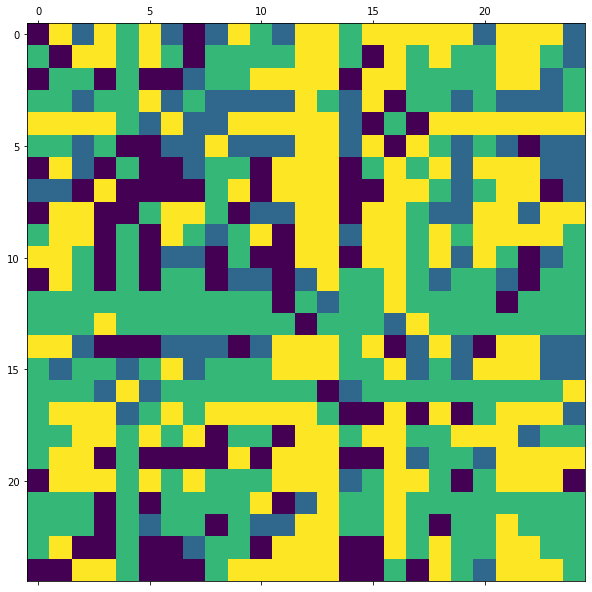

In [ ]:
plt.figure(figsize=(10,10))
plt.matshow(KeO, fignum=1)

In [ ]:
def individual(length):
  xi = np.arange(length)
  np.random.shuffle(xi)
  return xi.tolist()
xi = np.arange(25)
l=individual(25)


In [ ]:
  # indi = individual(25)

In [ ]:
#  n=int(np.sqrt(len(indi)))
#  A=np.array(indi).reshape(n,n)
#  obs_edges = set()
#  for i in np.arange(n):
#    for j in np.arange(n):
#      if j+1<n:
#        ii = A[i,j]
#        jj = A[i,j+1]
#        obs_edges.add((ii,jj,KeO[ii,jj]))
#      if i+1<n:
#        ii = A[i,j]
#        jj = A[i+1,j]
#        obs_edges.add((ii,jj,KeO[ii,jj]))
# obs_edges


In [ ]:
# A

In [ ]:
def indv_to_edgelist(indiv):
  n=int(np.sqrt(len(indiv)))
  A=np.array(indiv).reshape(n,n)
  obs_edges = set()
  for i in np.arange(n):
    for j in np.arange(n):
      if j+1<n:
        ii = A[i,j]
        jj = A[i,j+1]
        obs_edges.add((ii,jj,KeO[ii,jj]))
      if i+1<n:
        ii = A[i,j]
        jj = A[i+1,j]
        obs_edges.add((ii,jj,KeO[ii,jj]))
  return obs_edges

In [ ]:
# elist = indv_to_edgelist(indi)
# fit = np.sum([Ke[e[0],e[1]] for e in elist])
# len(elist)

In [ ]:
def fitness(indiv, target = 1):
    elist = indv_to_edgelist(indiv)
    return (np.sum([Ke[e[0],e[1]] for e in elist]))

In [ ]:
from past.builtins import xrange
from functools import reduce
from operator import add

def population(count, length):
  return [ individual(length) for x in xrange(count)]

def grade(pop, target):
  'Find average fitness for a population'
  summed = reduce(add, (fitness(x,target) for x in pop))
  return summed / (len(pop)*1.0)

In [ ]:
def edge_pairs(individual):
  n = int(np.sqrt(len(individual)))
  m = n
  A = np.array(individual).reshape(n,n)
  obs_edges = set()
  for i in np.arange(n):
    for j in np.arange(m):
      if j+1 < m:
        ii = A[i,j]
        jj = A[i,j+1]
        if i < j:
          obs = (ii,jj,3.0,((i,j),(i,j+1)))
        else:
          obs = (ii,jj,2.0,((i,j),(i,j+1)))
        obs_edges.add(obs)
      if i+1 < n:
        ii = A[i,j]
        jj = A[i+1,j]
        if i < j:
          obs = (ii,jj,0.0,((i,j),(i+1,j)))
        else:
          obs = (ii,jj,1.0,((i,j),(i+1,j)))
        obs_edges.add(obs)
  return list(obs_edges)

In [ ]:
# indin = individual(25)

In [ ]:
# n=5
# A = np.array(indin).reshape(n,n)
# A

In [ ]:
# v = edge_pairs(indin)
# v

In [ ]:
def update_boundary(child):
  n = int(np.sqrt(child.shape[0]))
  Cmat = child.reshape(n,n)
  candidate_pairs = edge_pairs(child)
  candidate_pairs = [c for c in candidate_pairs if (c[0] == -1) != (c[1] == -1)]

  results = []
  for cix in candidate_pairs:
    a = cix[0]
    b = cix[1]
    o = cix[2]
    ref = np.max([a,b])
    n_neighbours = np.argsort(Ke[ref,:])
    for nn in n_neighbours:
      if ((nn in child) == False) & (KeO[ref,nn]==o):
        results.append((ref, nn, o, Ke[ref,nn], cix[3], (a,b)))
        break
  if len(results) > 0:
    result = sample(results,1)[0]
    if result[5][0] == -1:
      rep_value = result[1]
      xi = int(result[4][0][0])
      yi = int(result[4][0][1])
    else:
      rep_value = result[1]
      xi = int(result[4][1][0])
      yi = int(result[4][1][1])

    Cmat[xi,yi] = rep_value
    child = Cmat.reshape(1,-1)[0]
    
  else:
    #idx_=np.arange(child.shape[0])
    #missing_pieces = idx_[np.isin(idx_,child)==False]
    missing_pieces = []
    for i in range(25):
      chi = 0
      for j in range(25):
        if child[j]==i:
          chi = 1
      if chi == 0:
        missing_pieces.append(i)
    np.random.shuffle(missing_pieces)
    
    iter = 0
    for i in np.arange(child.shape[0]):
      if child[i] == -1:
        child[i] = missing_pieces[iter]
        iter+=1

  return child

In [ ]:
# child = np.array(indin)
# n = int(np.sqrt(child.shape[0]))


In [ ]:
# child[:]=-1
# child[1]=13
# child[2]=14
# child[22]=15
# child[12]=16
# child[17]=17
# child[14]=11

In [ ]:
# Cmat = child.reshape(n,n)
# Cmat

In [ ]:
# Cmat = child.reshape(n,n)
# candidate_pairs = edge_pairs(child)
# candidate_pairs

In [ ]:
# Cmat = child.reshape(n,n)
# candidate_pairs = edge_pairs(child)
# candidate_pairs = [c for c in candidate_pairs if (c[0] == -1) != (c[1] == -1)]
# candidate_pairs

In [ ]:
#   results = []
#   for cix in candidate_pairs:
#     a = cix[0]
#     b = cix[1]
#     o = cix[2]
#     ref = np.max([a,b])
#     n_neighbours = np.argsort(Ke[ref,:])
#     for nn in n_neighbours:
#       if ((nn in child) == False) & (KeO[ref,nn]==o):
#         results.append((ref, nn, o, Ke[ref,nn], cix[3], (a,b)))
#         break
# results

In [ ]:
# from random import randint, random, sample
# from operator import add
# if len(results) > 0:
#     result = sample(results,1)[0]
#     if result[5][0] == -1:
#       rep_value = result[1]
#       xi = int(result[4][0][0])
#       yi = int(result[4][0][1])
#     else:
#       rep_value = result[1]
#       xi = int(result[4][1][0])
#       yi = int(result[4][1][1])

#     Cmat[xi,yi] = rep_value
    
#     # child = Cmat.reshape(1,-1)[0]
#     # print(child.shape[0])
# Cmat

In [ ]:
# child = Cmat.reshape(1,-1)[0]
# child

In [ ]:
def crossover(male,female):
  child = np.zeros(male.shape[0]).astype(int)
  child[:] = -1

  match_indices = np.where(male == female)
  child[match_indices] = female[match_indices]

  if child.sum() == -1*child.shape[0]:
    idx = np.random.choice(np.arange(child.shape[0]))
    child[idx] = male[idx]
  while(child.sum()<np.arange(child.shape[0]).sum()):
    child = update_boundary(child)

  return child

In [ ]:
def crossover1(indiv):
  n = np.random.randint(1, 23)
  indiv = np.roll(indiv,n)
  return indiv

In [ ]:
def crossover2(indiv):
  r1 = np.random.randint(1,23)
  r2 = np.random.randint(1,23)
  if r1!=r2:
    b = max(r1,r2)
    a = min(r1,r2)
    indiv[a:b+1] = indiv[a:b+1][::-1]
  return indiv


In [ ]:
def crossover3(indiv):
  r1 = np.random.randint(1,24)
  r2 = np.random.randint(1,24)
  r3 = np.random.randint(1,24)
  r4 = np.random.randint(1,24)
  r = np.array([r1,r2,r3,r4])
  l = sorted(r)
  if r1!=r2!=r3!=r4:
    s0 = indiv[:l[0]]
    s3 = indiv[l[2]:l[3]]
    s1 = indiv[l[0]:l[1]]
    s2 = indiv[l[1]:l[2]]
    sfi = indiv[l[3]:]
    inp = np.append(s0,s3)
    inp = np.append(inp,s2)
    inp = np.append(inp,s1)
    inp = np.append(inp,sfi)
    return inp
  
  return indiv
  


    


In [ ]:
from random import randint, random, sample
from operator import add

def evolve(pop, target, retain, random_select, mutate):
  graded = [(fitness(x,target),x) for x in pop]
  graded = [ x[1] for x in sorted(graded)]
  retain_length = int(len(graded)*retain)
  parents = graded[:retain_length]

  for individual in graded[retain_length:]:
    if random_select > random():
      parents.append(individual)

  for individua in parents:
    if mutate> random():
      # if(fitness_iter<0.7):    #decided based on every image
      #   if(0.5<random()):
      #     individual = np.roll(individual,5)
      #   else:
      #     n=5
      mat = np.array(individua)
      mat = mat.reshape(5,5)
      r = np.array([-1,-1,-1,-1,-1])
      B = np.array([np.roll(row, x) for row,x in zip(mat, r)])
      child = B.reshape(1,-1)[0]
      child = child.tolist()
      individua = child
      # else:
      #individual = np.roll(individual,1)

  parents_length = len(parents)
  desired_length = len(pop) - parents_length
  children = []
  while len(children) < desired_length:
    male = randint(0, parents_length-1)
    female = randint(0, parents_length-1)
    if male!=female:
      male = parents[male]
      female = parents[female]
      child = crossover(np.array(male),np.array(female))
      child = child.tolist()
      children.append(child)

  parents.extend(children)
  return parents

In [ ]:
# m=5
# n=5
# target = 1.0
# p_count = 1000
# p = population(p_count, Ke.shape[0])
# fitness_history = [grade(p, target),]
# fitness_history

In [ ]:
# iteration_img = []
# retain = 0.2
# random_select = 0.05
# mutate = 0.05
# pop = p
# graded = [(fitness(x,target),x) for x in pop]
# graded = [ x[1] for x in sorted(graded)]
# retain_length = int(len(graded)*retain)
# parents = graded[:retain_length]
# len(parents)

In [ ]:
# for individual in graded[retain_length:]:
#   if random_select > random():
#     parents.append(individual)
# len(parents)

In [ ]:
# for individual in parents:
#   if mutate> random():
#     individual = np.roll(individual,1)

In [ ]:
# parents_length = len(parents)
# desired_length = len(pop) - parents_length
# children = []
# male = randint(0, parents_length-1)
# female = randint(0, parents_length-1)
# if male!=female:
#       male = parents[male]
#       female = parents[female]
#       child = crossover_operator(np.array(male),np.array(female))
# child

In [ ]:
fitness_iter = 5

In [ ]:
n = np.sqrt(Ke.shape[0])
m = np.sqrt(Ke.shape[0])

target = 1.0
p_count = 1000
p = population(p_count, Ke.shape[0])
fitness_history = [grade(p, target),]

iteration_img = []
for i in xrange(400):
  p = evolve(p, target, retain = 0.4, random_select = 0.1, mutate = 0.1)

  fitness_iter = grade(p,target)
  fitness_history.append(fitness_iter)

  opt_index = idx = np.argmin([fitness(pi,0) for pi in p])
  iter_attempt = montage2d(puzzle_blocks[p[opt_index],:,:])
  iteration_img.append(iter_attempt)
  
  # idx = np.argmin([fitness(pi,0) for pi in p])
  # attempt = montage2d(puzzle_blocks[p[idx],:,:])

  # fig = plt.figure(figsize=(10,10))
  # plt.imshow(attempt,cmap = plt.cm.gray)

  print(fitness_iter)


4.188811916979198
3.7975792980374257
3.6514804867118595
3.607664624473515
3.596476115292714
3.5616859967822365
3.5177273506747224
3.50463533999264
3.503762316128565
3.4649631436088186
3.474696010093556
3.4467480955987018
3.4402022681478774
3.4259293998982416
3.4262146454862235
3.4104939784775166
3.4312704159240988
3.4149073493702113
3.3802229083231072
3.407377558074616
3.395779523685489
3.375652639435445
3.3743285951342243
3.3566526113120996
3.3620890715917326
3.3575583179351947
3.3388202908027944
3.32111153359822
3.3163734027248704
3.319581480151963
3.3051010549350806
3.296278335170679
3.2827623477018024
3.2596359453063455
3.272422966551156
3.270246780410718
3.2400070430881085
3.211926208551024
3.2344865079353413
3.2414678045530736
3.1881231935105077
3.1808356768584773
3.162308135475301
3.1686921411330085
3.164216750588229
3.0994607704843187
3.0608710149332605
3.0275353165622905
2.957962648461412
2.867907575148841
2.8114511713566315
2.675249896400165
2.5015220670151153
2.2943948159038

In [ ]:
idx = np.argmin([fitness(pi,0) for pi in p])
attempt = montage2d(puzzle_blocks[p[idx],:,:])

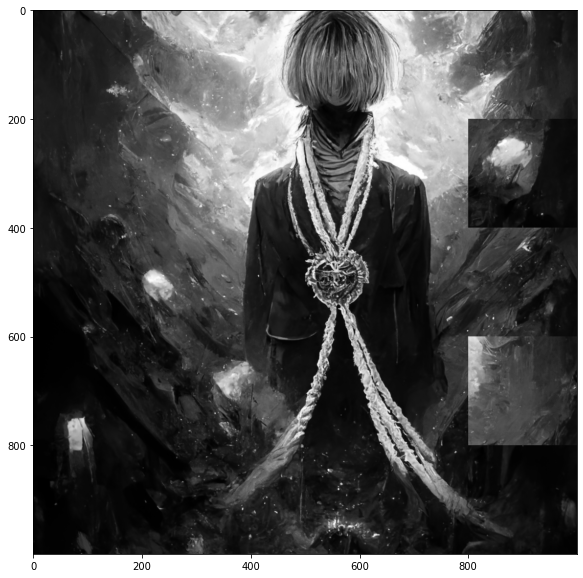

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.imshow(attempt,cmap = plt.cm.gray)

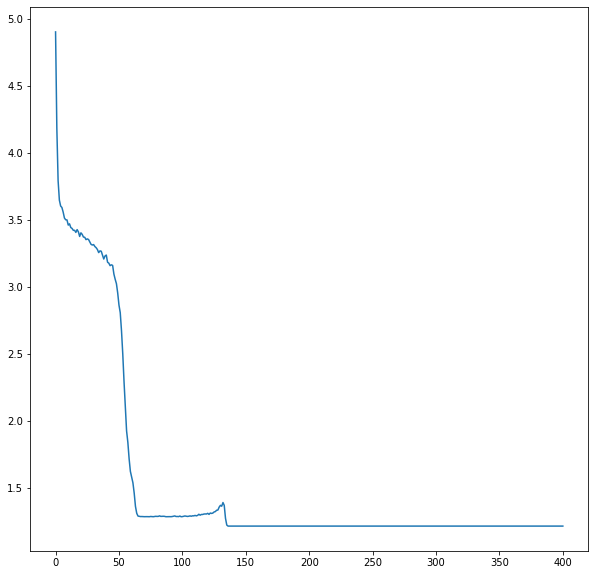

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.plot(fitness_history)

In [ ]:
out = [4.907068363625862,
 4.188811916979198,
 3.7975792980374257,
 3.6514804867118595,
 3.607664624473515,
 3.596476115292714,
 3.5616859967822365,
 3.5177273506747224,
 3.50463533999264,
 3.503762316128565,
 3.4649631436088186,
 3.474696010093556,
 3.4467480955987018,
 3.4402022681478774,
 3.4259293998982416,
 3.4262146454862235,
 3.4104939784775166,
 3.4312704159240988,
 3.4149073493702113,
 3.3802229083231072,
 3.407377558074616,
 3.395779523685489,
 3.375652639435445,
 3.3743285951342243,
 3.3566526113120996,
 3.3620890715917326,
 3.3575583179351947,
 3.3388202908027944,
 3.32111153359822,
 3.3163734027248704,
 3.319581480151963,
 3.3051010549350806,
 3.296278335170679,
 3.2827623477018024,
 3.2596359453063455,
 3.272422966551156,
 3.270246780410718,
 3.2400070430881085,
 3.211926208551024,
 3.2344865079353413,
 3.2414678045530736,
 3.1881231935105077,
 3.1808356768584773,
 3.162308135475301,
 3.1686921411330085,
 3.164216750588229,
 3.0994607704843187,
 3.0608710149332605,
 3.0275353165622905,
 2.957962648461412,
 2.867907575148841,
 2.8114511713566315,
 2.675249896400165,
 2.5015220670151153,
 2.294394815903821,
 2.1103005987302907,
 1.92882649644428,
 1.8435936838945657,
 1.72084408377942,
 1.626596721736926,
 1.5834132180505398,
 1.5415099124244933,
 1.4646871312953071,
 1.3654358051546978,
 1.3140073370487173,
 1.2932379607183573,
 1.2909767761529678,
 1.2894394143536048,
 1.2897084999775135,
 1.2889053612332233,
 1.2885482771706902,
 1.2888862518729614,
 1.2889053612332233,
 1.288371308112842,
 1.288371308112842,
 1.290122633300691,
 1.2889053612332233,
 1.288371308112842,
 1.2899734674739862,
 1.2913391607487184,
 1.2905075205943677,
 1.2909030392460994,
 1.29455105798321,
 1.2907571700814926,
 1.291404903050476,
 1.2916230560759214,
 1.2909120338976916,
 1.288371308112842,
 1.2886462087884527,
 1.288371308112842,
 1.2889053612332233,
 1.2885761074062327,
 1.289723251087081,
 1.292265594043205,
 1.294109395166296,
 1.2899197929663349,
 1.2900525319184712,
 1.28911427865405,
 1.2933668379449135,
 1.288301206730622,
 1.2891231115076849,
 1.2915962400965115,
 1.2938659209833154,
 1.2924496073815648,
 1.2904075351668876,
 1.2916827760807155,
 1.2943615795018684,
 1.292049821950863,
 1.294981936572913,
 1.2947251870531562,
 1.297940098162187,
 1.2948658179660761,
 1.2981381427031085,
 1.3065602924006474,
 1.299930920089632,
 1.3050484256511123,
 1.305031326970665,
 1.3083478402734579,
 1.3090027854955957,
 1.3085933930988978,
 1.3135350285744147,
 1.3057705454800392,
 1.31559715624456,
 1.312877929023731,
 1.3154791736378575,
 1.323766779212333,
 1.3267740629034461,
 1.3366525526238424,
 1.3379207456133178,
 1.3599801468353916,
 1.3733238469807731,
 1.366721406433389,
 1.3941899129070643,
 1.3732756597718303,
 1.2764944069922348,
 1.2262021126477531,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078,
 1.2183400272752078]

In [ ]:
out1 = [4.9029710866002585,
 4.671389640828282,
 4.503323516550486,
 4.362636228332734,
 4.262102233442402,
 4.168698408337464,
 4.097640566867585,
 4.040212472524694,
 4.0012911203914525,
 3.982763161413247,
 3.957241447175341,
 3.9382430393969563,
 3.9190067356856972,
 3.9029509635092614,
 3.8874138909981,
 3.875665209988859,
 3.868329520736582,
 3.8532748803231742,
 3.8521976281625063,
 3.8209760683627496,
 3.8158049345767058,
 3.798688898876714,
 3.796326126859643,
 3.800719570658898,
 3.7866657204293457,
 3.7883931787945837,
 3.7855048124677557,
 3.7747069946723815,
 3.7769105762459794,
 3.7820316477474765,
 3.7845861542349852,
 3.767713996767032,
 3.784337455069767,
 3.7846182129217176,
 3.7840484806779218,
 3.7794172826643835,
 3.7925142548327275,
 3.774632960292979,
 3.7772059833386242,
 3.784891951033757,
 3.7869986682224654,
 3.7627181026035887,
 3.7835879643620056,
 3.785253892650812,
 3.773595446486248,
 3.779673273239336,
 3.780945240142253,
 3.7695231160274543,
 3.7669235116716955,
 3.784838904261021,
 3.7855607269902167,
 3.778144619548447,
 3.784944622307664,
 3.77695921484671,
 3.7767095143807516,
 3.785293797372043,
 3.774960741554965,
 3.772069214706741,
 3.774384426436513,
 3.7927209761859686,
 3.7727426353620968,
 3.7738492237687495,
 3.7643922979336244,
 3.7650635276544833,
 3.777230925011109,
 3.7721035245480947,
 3.7695084785445268,
 3.7703756774661543,
 3.7654615949544996,
 3.77597184407451,
 3.777585330728925,
 3.7888537352173444,
 3.7869835496071635,
 3.768324364161764,
 3.7743006125612912,
 3.7667028554175523,
 3.7677370524168685,
 3.7705578414535004,
 3.777031355003062,
 3.7718601353350767,
 3.769894073395605,
 3.7778797254139773,
 3.778303476627692,
 3.7733541103605086,
 3.7881088731510797,
 3.7812678316058124,
 3.7874197639114375,
 3.7784037552056664,
 3.7752346979111002,
 3.770107089490213,
 3.770968308859462,
 3.783614900177482,
 3.7677826144299797,
 3.7755478702985834,
 3.7754779742281417,
 3.774740830112848,
 3.766458643613201,
 3.7754432348015197,
 3.7738587316172834,
 3.7838504133501862,
 3.7656125600811308,
 3.7818049725266274,
 3.7756399552845634,
 3.7672181564047884,
 3.7655629568489446,
 3.77360163826832,
 3.7816906196681823,
 3.7682167914757914,
 3.7778018458051807,
 3.76861691255774,
 3.7762656011710822,
 3.773511745535969,
 3.779682133278626,
 3.7747864498470483,
 3.7728535284288944,
 3.7762265223555915,
 3.778007378352575,
 3.7677480001780306,
 3.769076384821809,
 3.7733756558736067,
 3.783844129157692,
 3.776351539585787,
 3.769335721268892,
 3.76624174360834,
 3.76479330730285,
 3.778662892340014,
 3.7748444548018565,
 3.773987163436324,
 3.7768432805127357,
 3.7774305781212845,
 3.780307704535808,
 3.7725793583776346,
 3.774552607905681,
 3.7749164804697632,
 3.7786980273676445,
 3.7763140305265512,
 3.774025701746027,
 3.7727517290642867,
 3.774583013283021,
 3.783672719255366,
 3.774485687528671,
 3.7709194412123512,
 3.781496783217835,
 3.7821296373716486,
 3.788717111888003,
 3.7841038732023953,
 3.7717552259568885,
 3.7768261788278283,
 3.776744351296197,
 3.7737710968556875,
 3.775864806932337,
 3.7692025602762635,
 3.7762907758525515,
 3.7760069905830647,
 3.7699825882962177,
 3.773622023989959,
 3.7597686807413395,
 3.7836595499282297,
 3.777003172121597,
 3.7843222800216636,
 3.771493049079683,
 3.780241992986853,
 3.770492513759831,
 3.7866906301091854,
 3.7821236451107056,
 3.782146640750365,
 3.7755471753091823,
 3.7675772610097122,
 3.7841409097137193,
 3.779777843627188,
 3.771006881291292,
 3.777946579502783,
 3.77918332504155,
 3.7759747060632853,
 3.776230014663483,
 3.7804015595695346,
 3.7713465497950747,
 3.78414631892134,
 3.7858892410182317,
 3.780414639403019,
 3.7774509965928007,
 3.779687664352217,
 3.775979384706874,
 3.7788255827965633,
 3.7783327949769627,
 3.776364612136167,
 3.787201907051353,
 3.7911093124133477,
 3.774127514059953,
 3.77135132332859,
 3.783079145299797,
 3.776564987917999,
 3.774542578623859,
 3.782098862833134,
 3.7805993247123992,
 3.7806724419059075,
 3.7700382102582135,
 3.780248221178178,
 3.780614926995771,
 3.782064471392484,
 3.7799754837114365,
 3.784539053693862,
 3.780583212376329,
 3.779736788910696,
 3.779897735376405,
 3.7808361567168145,
 3.7822999727875612,
 3.7827619344302503,
 3.77601696879804,
 3.789535788141647,
 3.7832700832748536,
 3.7820001973584962,
 3.7708997775381023,
 3.781414579832596,
 3.7705434360736536,
 3.784032202930034,
 3.788316342456624,
 3.792852895627563,
 3.77614361969375,
 3.778346439296584,
 3.787646701810242,
 3.781549140968259,
 3.7806286391191275,
 3.783492013878112,
 3.788115177469843,
 3.7736362674123445,
 3.7812491837403033,
 3.7763083201572827,
 3.782076031041435,
 3.779709575389687,
 3.773093124592858,
 3.785537544072702,
 3.7703689835101484,
 3.790046413185933,
 3.7859811297068604,
 3.7774121718594467,
 3.7768922697534046,
 3.7920714707586227,
 3.778652727306241,
 3.776506928152406,
 3.769154038125172,
 3.776336635101442,
 3.775742131634436,
 3.7752965785307904,
 3.7818565126353842,
 3.7719121067416554,
 3.770702034840031,
 3.7875919803598377,
 3.76742546046969,
 3.7654509475142093,
 3.7670352893697285,
 3.7674709850036803,
 3.7629226059602496,
 3.777393834707071,
 3.780995180102762,
 3.7796541261054717,
 3.7795154015535033,
 3.780838135597549,
 3.7831901845491736,
 3.7805802440726417,
 3.777936186057847,
 3.777690412989716,
 3.776295893377153,
 3.785386090184599,
 3.774297022381695,
 3.7792215121599226,
 3.780590716937923,
 3.769294295420241,
 3.772332595233352,
 3.7701516482525714,
 3.7730500397753395,
 3.767352007143642,
 3.7678632262641245,
 3.7796101498642654,
 3.777630976214339,
 3.7745750600451906,
 3.778305356651949,
 3.7721832019391286,
 3.780808692286159,
 3.7680197518356966,
 3.7701870008221463,
 3.777356254626432,
 3.7768526195833907,
 3.776873711051788,
 3.7796698624936886,
 3.765059336773818,
 3.772159323013289,
 3.772010354084669,
 3.778242161759695,
 3.7768544353277167,
 3.7677670235024427,
 3.773674243985977,
 3.767181009058121,
 3.7771623362881512,
 3.769463931724089,
 3.772728855171413,
 3.778086848104731,
 3.774178190882875,
 3.78301258083526,
 3.776207728803403,
 3.7718250962277873,
 3.7771802845197535,
 3.7776373296975443,
 3.7830178713298013,
 3.7765538624963892,
 3.7782198942357983,
 3.7802408403240655,
 3.7796632343175123,
 3.7828529593925646,
 3.780448764370567,
 3.7810295951210557,
 3.782028171598621,
 3.779129798751794,
 3.7797852484719052,
 3.779528213686053,
 3.785172629719827,
 3.7746972050027097,
 3.7819624433754755,
 3.780288419991644,
 3.7771322725529517,
 3.783911792620215,
 3.7733833430583963,
 3.77699091798327,
 3.77844009679981,
 3.780710235141967,
 3.781840533918051,
 3.7779778373265005,
 3.7761807161892573,
 3.776857605028948,
 3.7831742626035965,
 3.774686371836493,
 3.7728761816367915,
 3.7784855809952305,
 3.7646088888789806,
 3.7664775950880407,
 3.776613333210628,
 3.7763439226298896,
 3.782363514531501,
 3.773779039686718,
 3.776372119423263,
 3.777370257941138,
 3.7678047245547943,
 3.78238101154967,
 3.773670395883484,
 3.7777447196004568,
 3.7722431565807084,
 3.7714128459375797,
 3.7729300846676996,
 3.7878847532202604,
 3.779920376052078,
 3.7751210328332214,
 3.774610713097298,
 3.778344605900237,
 3.778206365136138,
 3.7739155516782903,
 3.774148942156813,
 3.7767063598288675,
 3.7709491725856674,
 3.7680371268331903,
 3.780205327635959,
 3.773342724730693,
 3.7692665296681573,
 3.77483821405955,
 3.771495257845804,
 3.7763537357478545,
 3.7808260521104784,
 3.770217107526301,
 3.772840143317882,
 3.778301626788545,
 3.7669615579135267,
 3.774698270824975,
 3.7822568686921842,
 3.7751516013831226,
 3.781125371677813,
 3.7749416468953036,
 3.76795437342446,
 3.7851335294943036,
 3.775868558113983,
 3.777135597084141,
 3.7773503339370245,
 3.774018421295958,
 3.7760748665146866,
 3.764802637667058,
 3.7818066798092995,
 3.7809116482044143,
 3.7736509923993657,
 3.7854298723196833,
 3.7735021383360903,
 3.7772692087437427,
 3.773154328105871,
 3.7714901087356885,
 3.7804734301536183,
 3.7783143246553585,
 3.7733292374511938,
 3.7752395174003457,
 3.7814647019543477,
 3.7818083572728227,
 3.7751962676642856,
 3.78823696222998,
 3.775617515905245,
 3.764396891644434]

In [ ]:
out2 = [4.901829082470798,
 4.655831974128993,
 4.4757081456537335,
 4.35066431975241,
 4.220254555542775,
 4.078601820964611,
 3.944866497547716,
 3.7661780366639057,
 3.607388963936025,
 3.5501415248554493,
 3.5299574573081984,
 3.524078503418114,
 3.514745610489685,
 3.509957190601183,
 3.5094333062694085,
 3.507955072885995,
 3.501633924572752,
 3.5060043026975327,
 3.503421289079795,
 3.50554482181957,
 3.5037286358155275,
 3.4991338809123875,
 3.5026991172266757,
 3.4929176381243,
 3.5069416662757447,
 3.501146509994046,
 3.5063301263648583,
 3.5036281729856635,
 3.5058062288834595,
 3.4974610617325825,
 3.503049445062717,
 3.5071908322480057,
 3.5069756040413793,
 3.496157292913603,
 3.498653552421275,
 3.5056711155132603,
 3.501485438011451,
 3.506120620467496,
 3.5024756356232074,
 3.5053341514325767,
 3.506088104285381,
 3.5086058061726937,
 3.5034570158660157,
 3.503654808673654,
 3.500291184251035,
 3.500510162589353,
 3.503020298317868,
 3.5073763812124876,
 3.5017667571535185,
 3.5001674328531216,
 3.5000908076876356,
 3.497841092370394,
 3.4975568178051533,
 3.498162190630365,
 3.4929741563225516,
 3.501399059882528,
 3.505348999255154,
 3.500579263512213,
 3.499066088608351,
 3.501772705135129,
 3.5011339837443707,
 3.5020093304395896,
 3.5036642522398926,
 3.5083081884418683,
 3.501974172860522,
 3.4995697672569204,
 3.5033385213304586,
 3.5181958339055504,
 3.5003990852211877,
 3.503568457688062,
 3.501117703191347,
 3.505508911820022,
 3.50238665949273,
 3.5024195046784454,
 3.50195274506574,
 3.502564133886549,
 3.501529695071481,
 3.5000945664261733,
 3.5006833144167033,
 3.503639001591704,
 3.500421578523392,
 3.5018700558298845,
 3.5010526338405947,
 3.5034413875487633,
 3.5002533251102315,
 3.5028583275228304,
 3.500835698936103,
 3.4990879684422755,
 3.507092220917528,
 3.4992876644937057,
 3.502911208472927,
 3.5098273625457552,
 3.5054155467826593,
 3.5051727908918564,
 3.504790771517442,
 3.5078273987360906,
 3.4987261387965045,
 3.501870787027942,
 3.5007060880074103,
 3.50561746582806,
 3.4998756990723554,
 3.4991425518738573,
 3.509907874808686,
 3.50574415529428,
 3.5022824981977276,
 3.505444930426843,
 3.5028201378771864,
 3.50222273969481,
 3.5062961894900035,
 3.5054822878066325,
 3.502187052826899,
 3.5086309134015496,
 3.506275206855355,
 3.503018707162141,
 3.5023621253456856,
 3.5087569435826604,
 3.5081693751374505,
 3.5075982383378523,
 3.5069193320245637,
 3.49945848616525,
 3.5014361397696856,
 3.5000957822293812,
 3.499396775899967,
 3.5081215649246915,
 3.4999816842083566,
 3.5026907948637214,
 3.5015449590937013,
 3.5048002016039175,
 3.5135333446683763,
 3.507214479487249,
 3.5117428680297933,
 3.498395897135499,
 3.503321978338309,
 3.5035445626088415,
 3.5018349559986324,
 3.5074562414185313,
 3.5123942872013374,
 3.5061801021125953,
 3.5005179723679674,
 3.50571404738064,
 3.5025525219478646,
 3.503636973056982,
 3.506093479201241,
 3.5138323521678307,
 3.506676187836782,
 3.5045275621223,
 3.500119419948672,
 3.503345590169403,
 3.4993447560988167,
 3.5032565298910967,
 3.5068362267420823,
 3.5038772749900438,
 3.5082278885203935,
 3.501280521254468,
 3.5052277746984415,
 3.509109606084432,
 3.5028129937979426,
 3.493664754675086,
 3.502992179758132,
 3.5031096006246414,
 3.5063601842948637,
 3.5075921056732406,
 3.506986160137979,
 3.5012400257222778,
 3.500959880368536,
 3.514463348503718,
 3.5084042236417794,
 3.4990967590889115,
 3.507372848022607,
 3.5057150779085493,
 3.503926319812182,
 3.5036113455513336,
 3.5041279115764152,
 3.5100624066647503,
 3.506949956116297,
 3.5022888345252055,
 3.5073032663303034,
 3.511452791188869,
 3.5125760258778604,
 3.508843531893915,
 3.5052968324168137,
 3.50711317406043,
 3.506864381596054,
 3.5093759935131184,
 3.503454230086024,
 3.502336430789668,
 3.50617302742137,
 3.5048335373864847,
 3.502024085569865,
 3.505502799944343,
 3.5069480437117284,
 3.5029659054239417,
 3.5030246373922,
 3.505698023113121,
 3.503467599269646,
 3.497452081888113,
 3.502370845019993,
 3.507083017905606,
 3.505834988779511,
 3.505656344413006,
 3.5055645734125425,
 3.4998443169318394,
 3.5040213324716434,
 3.4969175243742923,
 3.5066516708020865,
 3.509031004347762,
 3.5003684810749833,
 3.509157968635045,
 3.5082305249327406,
 3.513532889645586,
 3.50451939932045,
 3.5053761569552253,
 3.498911212020323,
 3.5051100816606113,
 3.503557313381246,
 3.5053642018419673,
 3.5067660420469564,
 3.504762096336326,
 3.50581644456048,
 3.5095549780844295,
 3.5143898269160263,
 3.509946663462148,
 3.511566678211577,
 3.5143935848959473,
 3.513763553664533,
 3.503454299087073,
 3.51287073932633,
 3.5119650375543796,
 3.5063043890333976,
 3.5041856735203765,
 3.4990921935481993,
 3.515704148329548,
 3.507014348191321,
 3.5139147765462173,
 3.5106039830528504,
 3.5042146585676393,
 3.5037153883237147,
 3.507643164330075,
 3.5083509151130925,
 3.51210896209607,
 3.5105518941255456,
 3.509257207189581,
 3.520929265794163,
 3.508070425351758,
 3.5108907311751203,
 3.5109032157618354,
 3.504822836177864,
 3.511684607141841,
 3.509030629319335,
 3.507753397168943,
 3.5098268839364968,
 3.5075840882204377,
 3.5099909875945867,
 3.519280907486631,
 3.513831625060913,
 3.511105921018831,
 3.5100408531134377,
 3.5167405300148498,
 3.514013938848337,
 3.508499063504864,
 3.508390869519547,
 3.5104329943298933,
 3.5064263096384356,
 3.507935723155107,
 3.5047395970526103,
 3.5115872286146965,
 3.509461853005715,
 3.51243179856976,
 3.514704720631128,
 3.515038162682191,
 3.515860730786316,
 3.512805766168865,
 3.5132362560070796,
 3.505944485565283,
 3.5176790890882783,
 3.5158808512005413,
 3.522943145231833,
 3.5311874896732403,
 3.511112959238222,
 3.513708096543206,
 3.5239779768574313,
 3.5107151907609673,
 3.519783994197412,
 3.509718128169327,
 3.5143827096932028,
 3.5178405967204944,
 3.518744352515029,
 3.515311902604311,
 3.5108715086912983,
 3.5121468758196843,
 3.518012407434879,
 3.5191212776015353,
 3.5188171307687166,
 3.5124116047721428,
 3.521991469003024,
 3.522073778041872,
 3.518019503590509,
 3.5115489170216194,
 3.519567723107544,
 3.5272329573352748,
 3.522511464199517,
 3.52795078202813,
 3.5132532246919768,
 3.515083470485548,
 3.5168449801449553,
 3.5234038137412855,
 3.5174084167613184,
 3.513207094322651,
 3.5159829340407858,
 3.513141405198788,
 3.5239403289518076,
 3.5127724436390277,
 3.5156999584145248,
 3.5140904766517504,
 3.515817155869767,
 3.5237672412228487,
 3.5230162430611207,
 3.5190198310170775,
 3.513615352412259,
 3.5230591753587492,
 3.524830791621837,
 3.521790507850293,
 3.5259363643406845,
 3.5172489398723656,
 3.5256201397639617,
 3.5178601561089473,
 3.5165339482234006,
 3.516014009267743,
 3.5224980444908067,
 3.5240100965008447,
 3.5315400340783554,
 3.5230928585283974,
 3.5264097743772918,
 3.5213802075574354,
 3.521276940368671,
 3.51843210523729,
 3.5232166615353955,
 3.518955135396793,
 3.52393480285,
 3.5187202723155657,
 3.5155632208521177,
 3.523080639140836,
 3.532773789676508,
 3.525707304618714,
 3.527584999473601,
 3.5334691770939033,
 3.524593309523328,
 3.525628688105739,
 3.518988747383002,
 3.519851380579334,
 3.5188729444275326,
 3.511175834610175,
 3.515874891828298,
 3.5326852513760647,
 3.5198411272478536,
 3.5286745188434896,
 3.524117442810939,
 3.532737605329976,
 3.530405788460482,
 3.520854712658553,
 3.518472953704631,
 3.520095060526158,
 3.519293476386472,
 3.530272621294231,
 3.5306526787449717,
 3.528388530374568,
 3.535322569781397,
 3.535392417665547,
 3.524640922550302,
 3.523292016128452,
 3.536414098689042,
 3.5294949040871924,
 3.520315264000685,
 3.5270628931806196,
 3.5303271861660703,
 3.5343092216598366,
 3.523007349265903,
 3.52638812988395,
 3.5319690621674957,
 3.534837185767841,
 3.523852661941246,
 3.52601057168855,
 3.522343543203359,
 3.5280866733731004,
 3.5321916506320843,
 3.5271324611087413,
 3.5301430276658694,
 3.5312918187717854,
 3.532390383089282,
 3.52649079084637,
 3.5292632977379848,
 3.531745629591367,
 3.5261510553476536,
 3.5227799919059453,
 3.5308111786967413,
 3.518879196377307,
 3.536054716477504,
 3.518809139504526,
 3.535474122300221,
 3.5296771231545048,
 3.5421230526521748]

In [ ]:
out3 = [4.90937562646155,
 4.6520087302752104,
 4.509891680349394,
 4.391861806668049,
 4.3197216949407995,
 4.24416474629086,
 4.171128390058401,
 4.087321728290505,
 4.0337957679388925,
 3.9635246880246298,
 3.928171820301108,
 3.887387240115433,
 3.8387208815142393,
 3.7947171392721937,
 3.7741129396399042,
 3.7216549599871707,
 3.6975595814714,
 3.645503593366568,
 3.622003230077597,
 3.590689411800233,
 3.5546822759537964,
 3.548969502262273,
 3.5018449104473484,
 3.483621562459923,
 3.4445579414242613,
 3.4217414247293467,
 3.4050798003822185,
 3.3866218188592856,
 3.4078554835311836,
 3.369398388691496,
 3.3456869975124164,
 3.3288656311244673,
 3.3033569256937376,
 3.2848173914966794,
 3.267053857246314,
 3.2540289346873656,
 3.233557121683593,
 3.1899058143488235,
 3.189549580404942,
 3.182654833562847,
 3.1794634257827386,
 3.1449050968310006,
 3.1352511834392773,
 3.159362298756951,
 3.120112098569477,
 3.1131647000338485,
 3.1031023208009687,
 3.0949403919700247,
 3.102578556549998,
 3.083007856793958,
 3.0742805591351634,
 3.0684511999325768,
 3.062855444602236,
 3.0447734082585463,
 3.0451752440961584,
 3.023055672158789,
 3.0077255084357404,
 3.0098947306113417,
 3.006699453077874,
 2.9931954508698775,
 2.980268427687489,
 2.994736723876973,
 2.9998483339375968,
 3.0035013454195987,
 2.9633716982131775,
 2.968230858148126,
 2.957467465160747,
 2.952571976562297,
 2.93408370381983,
 2.945648417292923,
 2.9145873406806495,
 2.925237447046732,
 2.9296956457636893,
 2.89830571477306,
 2.86959431034674,
 2.8724186828190224,
 2.905305281114829,
 2.8600861940120814,
 2.8842173368292756,
 2.909294754755134,
 2.902757643047734,
 2.916575723980699,
 2.910730555253095,
 2.9218437044988446,
 2.8951473239527754,
 2.8900758892700456,
 2.866905692127159,
 2.86918194232998,
 2.8557585670551737,
 2.855197200322149,
 2.8484144294600497,
 2.86524976139109,
 2.8286202702384884,
 2.8574228445181657,
 2.834944421522721,
 2.8364565264916797,
 2.840601920458657,
 2.8316897755889654,
 2.835750876819726,
 2.8335892786338506,
 2.8296802491653716,
 2.8219544517768207,
 2.8287490868272367,
 2.7968362930293464,
 2.8146176150553113,
 2.8000904941561697,
 2.8131195928016255,
 2.788377336496916,
 2.794512173974803,
 2.8004628313908793,
 2.7706096934088866,
 2.7721353904125285,
 2.7936211249618013,
 2.7770400150965258,
 2.7791002410465344,
 2.801159855564469,
 2.8009963228183894,
 2.7822394389453904,
 2.8048649970045396,
 2.793752701918981,
 2.7765240707053147,
 2.77581684762988,
 2.7564043856698417,
 2.759652486892964,
 2.7780854452497006,
 2.756003788332488,
 2.747823809025706,
 2.7664429451280625,
 2.786298092157842,
 2.793001717548606,
 2.8042604445126154,
 2.7721193207360844,
 2.745060741827879,
 2.7703136874976755,
 2.773330268044969,
 2.7870895119331434,
 2.780437945987801,
 2.801526596141191,
 2.7882364538526563,
 2.7580419840239143,
 2.7909398882488436,
 2.7875829646711114,
 2.781569898491168,
 2.79463523999928,
 2.7660390377255744,
 2.764691586180663,
 2.7615659830394006,
 2.7680949177255783,
 2.764442951387008,
 2.7472463110719656,
 2.758578311372078,
 2.7705812199839674,
 2.7754059972965006,
 2.769108680628179,
 2.7485437346673636,
 2.7452918922166365,
 2.753403312711269,
 2.724656208312094,
 2.725001211971253,
 2.705437117268219,
 2.7236696826244087,
 2.7128461467714,
 2.7048679788156487,
 2.7086485006568695,
 2.6910882247659695,
 2.7053104841207785,
 2.729937103732565,
 2.7039132150609704,
 2.7018059548327757,
 2.7166677562193273,
 2.668581785478097,
 2.696955296905706,
 2.7256339852911826,
 2.661396011669187,
 2.712988470070814,
 2.682906212890204,
 2.70618175284148,
 2.6868049890707066,
 2.68523403420041,
 2.6980005214883427,
 2.6974006601458647,
 2.6882118186312836,
 2.6964720890879756,
 2.6636413090582147,
 2.714599651057511,
 2.7040892037861375,
 2.6939961676694373,
 2.6976234545171476,
 2.6753781359363877,
 2.6912373616917318,
 2.7065493202115105,
 2.683982535607879,
 2.6855602678719723,
 2.6991737725385043,
 2.709645501459797,
 2.690114548865165,
 2.6914196180915297,
 2.66838414867204,
 2.721290925844256,
 2.6862240323415136,
 2.688200942539589,
 2.669265651486861,
 2.700735520547788,
 2.7584325543858603,
 2.680848397750671,
 2.694222975491248,
 2.6584077813193367,
 2.692251585631743,
 2.6816614162881924,
 2.704694051253998,
 2.683356568177614,
 2.6690122818693016,
 2.6655560116780137,
 2.6220621357095677,
 2.647473745506834,
 2.6491519431598376,
 2.6282479875643907,
 2.6336657570214235,
 2.6574675839052455,
 2.6776219364196225,
 2.6657253898996807,
 2.6752843820670584,
 2.6735241103159737,
 2.697244635490687,
 2.6861692926236933,
 2.6459669754912993,
 2.6116633437774794,
 2.6425314329950456,
 2.6377538337837296,
 2.615710107342504,
 2.634522069579293,
 2.631683020094273,
 2.630880069600653,
 2.6176068184324994,
 2.6180654735526794,
 2.637014194384177,
 2.6119481995799045,
 2.629577107770239,
 2.620666769711189,
 2.628880440658259,
 2.6044080266890424,
 2.6396710430156523,
 2.629146163562341,
 2.6170005162269843,
 2.6087431731640183,
 2.6160992085979373,
 2.623272161430538,
 2.6053579301034246,
 2.635195600936731,
 2.6058984699494228,
 2.6213248372771467,
 2.6190483935036415,
 2.6041106046857694,
 2.6121941075493136,
 2.5834342271041026,
 2.5973968133892424,
 2.6093619649395468,
 2.6034571490710534,
 2.6101455220860608,
 2.6241115244920534,
 2.616120815625323,
 2.6255170733711917,
 2.589165855474043,
 2.6124916868221115,
 2.634235670391711,
 2.6030887079228298,
 2.6134403883995363,
 2.624584311043517,
 2.6027264566432247,
 2.5978072101790057,
 2.599452857653179,
 2.607697468918174,
 2.603921131424043,
 2.5722555836794236,
 2.5936762441897416,
 2.579941491196068,
 2.5939038265604726,
 2.5800259305416153,
 2.5911870840325166,
 2.584340267196664,
 2.5885275933513445,
 2.5853766917076877,
 2.582266689726633,
 2.600137202465612,
 2.6269244217442376,
 2.571176186554187,
 2.58784441352943,
 2.527170989868705,
 2.5641543727044938,
 2.5752169758782166,
 2.579147647111185,
 2.566035765977868,
 2.581642874558634,
 2.5730013928154825,
 2.583278861487459,
 2.581492919971473,
 2.5973467314072476,
 2.5876800892656098,
 2.559778136206279,
 2.584323895966218,
 2.5668711152563524,
 2.571727318954367,
 2.5609142130201765,
 2.545714814245539,
 2.5588691307752844,
 2.5500186475473297,
 2.543372466860459,
 2.5540084683741306,
 2.578807991738243,
 2.5902157689144034,
 2.602342190436997,
 2.56266783149672,
 2.5893445738232077,
 2.5645792283715325,
 2.5711866783313675,
 2.5589028755121337,
 2.5715437886867214,
 2.565228192713276,
 2.541434079795899,
 2.590171083619609,
 2.588396938031992,
 2.5470007307571207,
 2.555158451650373,
 2.5375532055250223,
 2.5741562187510545,
 2.567502240114528,
 2.566738453960257,
 2.595433258918572,
 2.586272742021231,
 2.5651207019430307,
 2.565458225417535,
 2.5524349013791956,
 2.5691864253992613,
 2.560634429769285,
 2.542368679105501,
 2.5645540659291197,
 2.5557829770371794,
 2.552861508223504,
 2.549724996076309,
 2.5264470793287064,
 2.5812505913511403,
 2.5652445576447236,
 2.552127901373798,
 2.52527217125695,
 2.5522859806958422,
 2.577826716740908,
 2.5574812321420675,
 2.5505541209711358,
 2.5874095778170774,
 2.5831358935206423,
 2.560359396845739,
 2.5684576814828337,
 2.533600033202711,
 2.5560771707074967,
 2.5529073153941595,
 2.5763993042946125,
 2.5619045016329287,
 2.55573556147256,
 2.543058471423584,
 2.527518984428889,
 2.538414996887137,
 2.540778623512219,
 2.5209211933860147,
 2.5399329984839083,
 2.514829281984018,
 2.5118130958535403,
 2.5454139755848364,
 2.53514874140084,
 2.520997526081693,
 2.511081523063055,
 2.5433256757674454,
 2.508808234702298,
 2.4945166146240423,
 2.5215801709077685,
 2.5029757272303352,
 2.5413367221729204,
 2.5241221917189702,
 2.511336930058221,
 2.4989177202817494,
 2.501505531633786,
 2.5130306384531274,
 2.5284346875497503,
 2.5421905343125877,
 2.5378280118213685,
 2.5001193577215157,
 2.487270547149951,
 2.499462221108993,
 2.494013877413362,
 2.5217397449284125,
 2.489157974195746,
 2.5001748395063763,
 2.4872483433457844,
 2.506188419306163,
 2.5056683973558234,
 2.510223652868424,
 2.5158278114170614,
 2.5156155221489818,
 2.485610818753798,
 2.48200436173017,
 2.515493072062193,
 2.5219505344908995]

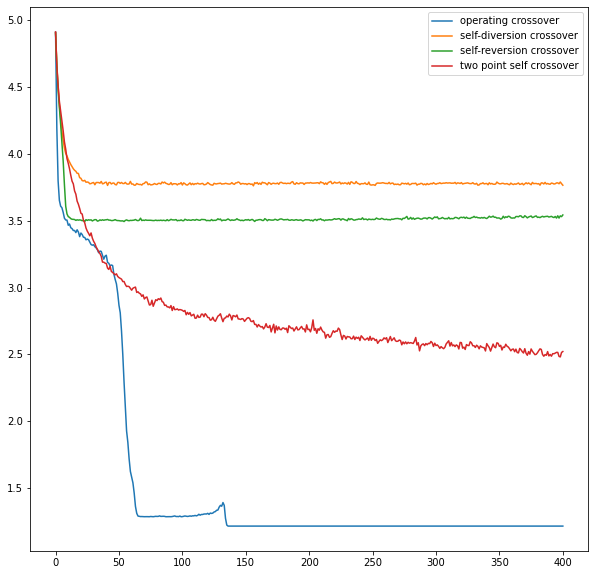

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.plot(out, label = "operating crossover")
plt.plot(out1, label = "self-diversion crossover")
plt.plot(out2, label = "self-reversion crossover")
plt.plot(out3, label = "two point self crossover")
leg = plt.legend()

In [ ]:
inpu = individual(25)
inpu = np.array(inpu)
inpu

array([11,  5,  7, 15,  6, 23, 20,  0, 13, 19,  8,  4,  2, 24, 21, 22, 14,
       10,  9,  1, 17, 16, 12, 18,  3])

In [ ]:
crossover3(inpu)

array([11,  5,  7, 15,  6, 23, 20,  0, 14, 10, 24, 21, 22, 13, 19,  8,  4,
        2,  9,  1, 17, 16, 12, 18,  3])

In [ ]:
# inpu[2:4] = inpu[2:4][::-1]
# inpu

In [ ]:
#   r1 = np.random.randint(1,24)
#   r2 = np.random.randint(1,24)
#   r3 = np.random.randint(1,24)
#   r4 = np.random.randint(1,24)
#   r = np.array([r1,r2,r3,r4])
# r

In [ ]:
#     l = sorted(r)
#     print(l)
#     s0 = inpu[:l[0]]
#     s3 = inpu[l[2]:l[3]]
#     s1 = inpu[l[0]:l[1]]
#     s2 = inpu[l[1]:l[2]]
#     sfi = inpu[l[3]:]
#     print(s0,s1,s2,s3,sfi)

# inp = np.append(s0,s3)
# inp = np.append(inp,s2)
# inp = np.append(inp,s1)
# inp = np.append(inp,sfi)